Here we explore clustering companies based on their company description like we did in the other versions of this model but in this version we explore if there are any performance improvements by using Hamming Distance instead of Euclidean Distance.

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import datetime
import os
import seaborn as sns
import math as mth
import pickle
import re
import nltk
import spacy
import sklearn

import tika
from tika import parser

import bokeh
from bokeh.plotting import *
from bokeh.io import output_notebook
from bokeh.models import Toggle, BoxAnnotation, CustomJS, HoverTool

output_notebook()

from sklearn.manifold import TSNE

sns.set_style("white")

%matplotlib inline

from IPython.display import display

from IPython.display import HTML

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Loading BokehJS ...

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zanderl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Existing Clients only. Excludes ETF funds + Parent and subsidiary companies + US/Canada only + Ipreo investment approach data + additional data from Form-ADV filings where available
df1 = pd.read_csv('C:/Users/zanderl/Documents/Data Science/SFDC Similar Companies Project/SFDC and Ipreo CoData.csv',
                  encoding='latin1')



# Excludes ETF funds, Parent and subsidiary companies, US/Canada only, include additional data from Form-ADV filings where available
#df1 = pd.read_csv('C:/Users/zanderl/Documents/Data Science/SFDC Similar Companies Project/SFDC Company Data Filtered for US Includes Subsidiaries with Form ADV.csv',encoding='latin1')

# Excludes ETF funds, Parent and subsidiary companies, US/Canada only
#df1 = pd.read_csv('C:/Users/zanderl/Documents/Data Science/SFDC Similar Companies Project/SFDC Company Data Filtered for US Includes Subsidiaries.csv',encoding='latin1')

# Parent company level data only, US/Canada only
#df1 = pd.read_csv('C:/Users/zanderl/Documents/Data Science/SFDC Similar Companies Project/SFDC Company Data Filtered for US and Parent Company.csv',encoding='latin1')

# Subsidiary level company data, US/Canada only
#df1 = pd.read_csv('C:/Users/zanderl/Documents/Data Science/SFDC Similar Companies Project/SFDC Company Data Filtered for US.csv',encoding='latin1')

#df1 = pd.read_csv('C:/Users/zanderl/Documents/Data Science/SFDC Similar Companies Project/SFDC Company Data.csv', encoding='latin1')
#df1 = pd.read_csv('C:/Users/zanderl/Documents/Data Science/SFDC Similar Companies Project/PA Greenfield Ideas Cleaned.csv', encoding='latin1')

In [4]:
#df1.index = df1['Relationship Name']

df1.index = df1['Account Name']
#df1.drop(labels=['Account Name'],axis=1,inplace=True)

df1.shape
df1.head(5)

(994, 64)

,Account Name,Business Description,Business Description Plain,Investment Approach,Billing Country,Billing State/Province,Billing City,Account ID (Case Safe),S&P Capital IQ Company ID,KeyInstn - SNL,...,Dominant Style,Dominant Orientation,Contact Equity Assets ($m),Account Equity Assets Under Management ($m),City,State,Country,Geographic Region,CRM,Primary Contacts
Account Name,,,,,,,,,,,,,,,,,,,,,
12 West Capital Management LP,12 West Capital Management LP,12 West Capital Management LP is an employee o...,12 West Capital Management LP is an employee o...,NaN,United States,NY,New York,0014000000diOsEAAU,IQ158358908,4321055.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1832 Asset Management L.P.,1832 Asset Management L.P.,1832 Asset Management L.P. is a privately owne...,1832 Asset Management L.P. is a privately owne...,NaN,Canada,ON,Toronto,0014000000FGy4YAAT,IQ1029378,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"1919 Investment Counsel, LLC","1919 Investment Counsel, LLC","1919 Investment Counsel, LLC operates as a sub...","1919 Investment Counsel, LLC operates as a sub...",NaN,United States,MD,Baltimore,0014000001llGwcAAE,IQ59705013,4096352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361° Capital LLC,361° Capital LLC,361° Capital LLC is an employee owned hedge fu...,361° Capital LLC is an employee owned hedge fu...,NaN,United States,CO,Denver,0014000000cCrlGAAS,IQ116742844,4117083.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"3G Capital, Inc.","3G Capital, Inc.","3G Capital, Inc. is a private equity firm spec...","3G Capital, Inc. is a private equity firm spec...",NaN,United States,NY,New York,0014000000K85RQAAZ,IQ23471434,4189265.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
coData_df = pd.DataFrame(df1,columns=['Business Description'],index=df1.index)

In [6]:
coData_df.head()

,Business Description
Account Name,
12 West Capital Management LP,12 West Capital Management LP is an employee o...
1832 Asset Management L.P.,1832 Asset Management L.P. is a privately owne...
"1919 Investment Counsel, LLC","1919 Investment Counsel, LLC operates as a sub..."
361° Capital LLC,361° Capital LLC is an employee owned hedge fu...
"3G Capital, Inc.","3G Capital, Inc. is a private equity firm spec..."


In [7]:
df1.loc['12 West Capital Management LP']['Business Description']

'12 West Capital Management LP is an employee owned hedge fund sponsor. It primarily provides its services to pooled investment vehicles. The firm launches and manages hedge fund for its clients. It invests in the public equity and fixed income markets across the globe. The firm invests in value stocks of small-cap companies. It employs a long/short equity strategy to make its investments. 12 West Capital Management LP is based in New York City. In managing the Funds, we invest both long and short, in equity, equity related, and credit securities. In addition, we may also invest in preferred stocks, warrants, rights, options, swaps and other derivative instruments, bonds and other fixed income securities, futures and money market instruments. We believe that investing in companies with an equity market capitalization of U.S. $2.5 billion or less (\x93Small Cap\x94) offers the greatest opportunity to generate superior compounded annual net returns, predominantly because: (i) There is a 

In [8]:
df1['Business Description'] = df1['Business Description'].str.lower()
coData_df['Business Description'] = coData_df['Business Description'].str.lower()

In [9]:
#pd.isnull(coData_df).sum()

In [10]:
len(coData_df['Business Description'])

994

In [11]:
# train = coData_df['Business Description'][:495]
# test = coData_df['Business Description'][495:]

# train.shape
# test.shape

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(coData_df['Business Description'], test_size=0.5,random_state=0)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import DBSCAN
import gensim
import nltk

C:\Users\zanderl\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [13]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1,4),
    stop_words='english',
    min_df = 10,
    max_df = 0.60
    # Original value: max_df = 0.8
)

# 3/12/2018: Changed ngram_range=(1,2) to ngram_range(1,3)

In [14]:
%%time
X = vectorizer.fit_transform(coData_df['Business Description'])
X

Wall time: 988 ms


In [15]:
#vectorizer.fit(coData_df['Business Description'])
#vectorizer_vocab = pd.Series(vectorizer.vocabulary_)
#vectorizer_vocab

type(X)
X.shape

scipy.sparse.csr.csr_matrix

(994, 3562)

In [16]:
# let's inspect some of the features that were extracted
feat_names = vectorizer.get_feature_names()[:]
len(feat_names)

#vect.get_feature_names()[500:]

3562

In [17]:
#feat_names[(int(len(feat_names)/2)):]

In [18]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.neighbors import ball_tree, BallTree

In [20]:
nmf_model = NMF(n_components=256)

In [21]:
%%time
X_NMF_transformed = nmf_model.fit_transform(X)

Wall time: 1min 45s


In [22]:
nmf_model.reconstruction_err_

18.253983368021274

In [23]:
X_NMF_transformed.shape

(994, 256)

In [24]:
# svd = TruncatedSVD(n_components=2900)

# Original preferred value is n_components = 128
# PA greenfield 1811

In [25]:
# %%time
# X_transformed = svd.fit_transform(X)

In [26]:
# svd.explained_variance_ratio_.sum()
# X_transformed.shape

In [27]:
%%time

index = BallTree(X_NMF_transformed,
            metric='hamming')

#index = BallTree(X_transformed)

Wall time: 10 ms


In [29]:
%%time

index.query(X_NMF_transformed[[0]],k=11,dualtree=True)

#index.query(X_transformed[[0]],k=11,dualtree=True)

# This was originally set ot k=10
# dualtree was originally set to False

Wall time: 2 ms


(array([[ 0.        ,  0.16796875,  0.16796875,  0.171875  ,  0.171875  ,
          0.1796875 ,  0.1796875 ,  0.1796875 ,  0.18359375,  0.18359375,
          0.18359375]]),
 array([[  0, 658, 370, 821, 125, 950, 556, 615, 398, 773, 662]], dtype=int64))

In [82]:
test_company = 'Hirtle, Callaghan & Co., LLC'
i = df1.index.get_loc(test_company)

In [83]:
distances, indices = index.query(X_NMF_transformed[[i]],k=11,dualtree=True)

#distances, indices = index.query(X_transformed[[i]],k=11,dualtree=True)

# Tried this to see if it would improve results. Need to look into how to use it more because it threw an error
#distances, indices = index.query_radius(X_transformed[[i]],r=0.3,count_only=False)

In [84]:
df1['Business Description'].iloc[indices[0]]

Account Name
Hirtle, Callaghan & Co., LLC             hirtle, callaghan & co., llc is a privately ow...
Palos Management Inc.                    palos management inc. is based in montreal, qu...
FRÜH & PARTNER VERMÖGENSVERWALTUNG AG    früh & partner vermögensverwaltung ag is based...
Sound Point Capital Management, LP                    sound point capital is a hedge fund.
Paragon Associates, Ltd.                 paragon associates, ltd. is a privately owned ...
Bluespruce Investments, LP                                 blue spruce lp is a hedge fund.
Ninepoint Partners LP                            ninepoint partners lp is based in canada.
Sandia Holdings, LLC                     sandia holdings, llc is headquartered in green...
Man Investments Limited                  man investments limited operates as a subsidia...
FormulaFolio Investments, LLC            formulafolio investments, llc is an employee o...
Stone Ridge Asset Management LLC         stone ridge asset management llc is 

In [85]:
SimilarCo_df = pd.DataFrame(df1['Business Description'].iloc[indices[0]])
SimilarCo_df.shape

(11, 1)

In [86]:
# for i in SimilarCo_df.index:
#     print(''.join(i))

In [87]:
#SimilarCo_df.iloc[0][0]
#SimilarCo_df.iloc[1][0]
#SimilarCo_df.iloc[2][0]
#SimilarCo_df.iloc[3][0]
#SimilarCo_df.iloc[10][0]

In [88]:
raw_documents = []
df_range = range(0,len(SimilarCo_df),1)

for i in df_range:
    raw_documents.append(SimilarCo_df.iloc[i][0])

In [89]:
vect2 = TfidfVectorizer(min_df=1,
                       ngram_range=(1,4),
                       max_df=0.60)

tfidf2 = vect2.fit_transform(raw_documents)
tfidf_format = (tfidf2 * tfidf2.T).A
tfidf_similarity = tfidf_format[0]

In [90]:
tfidf2.shape

(11, 807)

In [91]:
from nltk.tokenize import word_tokenize
gen_docs = [[w.lower() for w in word_tokenize(text)]
           for text in raw_documents]


dictionary = gensim.corpora.Dictionary(gen_docs)

corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]

# NOTE: num_mnz is the number of tokens

tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)
s = 0
for i in corpus:
    s += len(i)
s

TfidfModel(num_docs=11, num_nnz=220)


220

In [92]:
#for i in range(len(dictionary)):
#    print(i, dictionary[i])

In [93]:
sims = gensim.similarities.Similarity(gensim.utils.os.getcwd(), tf_idf[corpus],
                                     num_features=len(dictionary))

print(sims)
print(type(sims))

Similarity index with 11 documents in 0 shards (stored under C:\Users\zanderl)
<class 'gensim.similarities.docsim.Similarity'>


In [94]:
query_doc = [w.lower() for w in word_tokenize(SimilarCo_df.iloc[0][0])]
query_doc_bow = dictionary.doc2bow(query_doc)
query_doc_tf_idf = tf_idf[query_doc_bow]

SimilarCo_df['tfidf Similarity'] = tfidf_similarity
SimilarCo_df['NLTK tfidf Similarity'] = sims[query_doc_tf_idf]
SimilarCo_df['Hamming Distances'] = distances.T

In [95]:
SimilarCo_df.sort_values(by='Hamming Distances',ascending=True,inplace=True)
SimilarCo_df

,Business Description,tfidf Similarity,NLTK tfidf Similarity,Hamming Distances
Account Name,,,,
"Hirtle, Callaghan & Co., LLC","hirtle, callaghan & co., llc is a privately ow...",1.000000,1.000000,0.000000
Palos Management Inc.,"palos management inc. is based in montreal, qu...",0.000000,0.022022,0.207031
FRÜH & PARTNER VERMÖGENSVERWALTUNG AG,früh & partner vermögensverwaltung ag is based...,0.000000,0.037739,0.207031
"Sound Point Capital Management, LP",sound point capital is a hedge fund.,0.009278,0.016388,0.210938
"Paragon Associates, Ltd.","paragon associates, ltd. is a privately owned ...",0.039539,0.048383,0.210938
"Bluespruce Investments, LP",blue spruce lp is a hedge fund.,0.009443,0.017549,0.214844
Ninepoint Partners LP,ninepoint partners lp is based in canada.,0.000000,0.002833,0.218750
"Sandia Holdings, LLC","sandia holdings, llc is headquartered in green...",0.029572,0.059861,0.218750
Man Investments Limited,man investments limited operates as a subsidia...,0.012245,0.018093,0.222656


In [96]:
SimilarCo_df.sort_values(by='tfidf Similarity',ascending=False,inplace=True)
SimilarCo_df

,Business Description,tfidf Similarity,NLTK tfidf Similarity,Hamming Distances
Account Name,,,,
"Hirtle, Callaghan & Co., LLC","hirtle, callaghan & co., llc is a privately ow...",1.000000,1.000000,0.000000
Stone Ridge Asset Management LLC,stone ridge asset management llc is a privatel...,0.078980,0.081059,0.222656
"FormulaFolio Investments, LLC","formulafolio investments, llc is an employee o...",0.045913,0.099891,0.222656
"Paragon Associates, Ltd.","paragon associates, ltd. is a privately owned ...",0.039539,0.048383,0.210938
"Sandia Holdings, LLC","sandia holdings, llc is headquartered in green...",0.029572,0.059861,0.218750
Man Investments Limited,man investments limited operates as a subsidia...,0.012245,0.018093,0.222656
"Bluespruce Investments, LP",blue spruce lp is a hedge fund.,0.009443,0.017549,0.214844
"Sound Point Capital Management, LP",sound point capital is a hedge fund.,0.009278,0.016388,0.210938
Palos Management Inc.,"palos management inc. is based in montreal, qu...",0.000000,0.022022,0.207031


In [44]:
# for i in SimilarCo_df.index:
#    print(''.join(i))

In [52]:
# ngram_range(1,4)
SimilarCo_df.sort_values(by='tfidf Similarity',ascending=False,inplace=True)
SimilarCo_df

,Business Description,tfidf Similarity,NLTK tfidf Similarity,Hamming Distances
Account Name,,,,
"GAMCO Investors, Inc.","gamco investors, inc. is a publicly owned hold...",1.000000,0.999999,0.000000
Intact Investment Management Inc.,"ing investment management, inc. operates as a ...",0.078918,0.086856,0.281250
"Voce Capital Management, LLC","voce capital management, llc was founded in 20...",0.068561,0.164243,0.289062
"Alambic Investment Management, L.P.","alambic investment management, l.p. offers inv...",0.054072,0.145743,0.281250
Man Investments Limited,man investments limited operates as a subsidia...,0.040568,0.037343,0.281250
Governors Lane LP,governors lane lp is a private investment firm...,0.035084,0.100757,0.281250
Stone Ridge Asset Management LLC,stone ridge asset management llc is a privatel...,0.023888,0.042011,0.296875
Richardson GMP Limited,richardson gmp limited is a privately owned in...,0.013124,0.029662,0.281250
Ninepoint Partners LP,ninepoint partners lp is based in canada.,0.005061,0.007345,0.296875


In [48]:
# SimilarCo_df.sort_values(by='Hamming Distances',ascending=True,inplace=True)
# SimilarCo_df

In [49]:
# SimilarCo_df.sort_values(by='tfidf Similarity',ascending=False,inplace=True)
# SimilarCo_df

In [397]:
#SimilarCo_df['Business Description'].iloc[0]

In [398]:
#SimilarCo_df['Business Description'].iloc[1]

In [177]:
#SimilarCo_df['Business Description'].iloc[3]

In [398]:
%%time
clf = DBSCAN(min_samples=2)

#labels = clf.fit_predict(X_NMF_transformed)
#labels = clf.fit_predict(X_transformed)
labels = clf.fit_predict(X)

Wall time: 1.26 s


In [399]:
labels.shape

(2987,)

In [400]:
#n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_ = len(set(labels))
print ("\nTotal clusters discovered: %d" % n_clusters_)

clustered = labels


Total clusters discovered: 15


In [401]:
labels.shape

(2987,)

In [406]:
clustered_series = pd.Series(index=coData_df.index, data=clustered.flatten())
#clustered_series =clustered_series[clustered_series != -1]
clustered_series_all = pd.Series(index=df1, data=clustered.flatten())
#clustered_series_all = pd.Series(index=X_transformed, data=clustered.flatten())

<Container object of 15 artists>

Text(0.5,1,'Cluster Member Counts')

Text(0.5,0,'Stocks in Cluster')

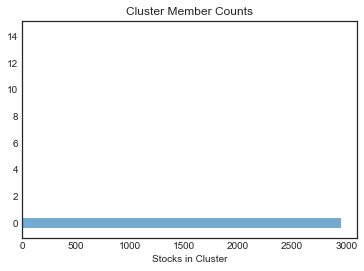

In [423]:
plt.barh(
    #xrange(len(clustered_series.value_counts())),
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts(),
    alpha=0.625
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')

In [416]:
pair_clusters = clustered_series.value_counts()[clustered_series.value_counts()<3].index.values

In [417]:
print(pair_clusters)
print("\nTotal pair clusters discovered: %d" % len(pair_clusters))

[11  9  7  3 12 10  6  2]

Total pair clusters discovered: 8


In [418]:
pair_clusters[:100]

array([11,  9,  7,  3, 12, 10,  6,  2], dtype=int64)

In [436]:
#cluster2 = clustered_series['Westfield Capital Management Company, L.P.']
#coData_df.iloc[clustered==cluster2]

In [427]:
clustered_series.shape

(2987,)

In [437]:
clustered_series.sort_values(axis=0,ascending=False).head(20)

Account Name
Woodson Capital Management, LLC                                                                        13
Atika Capital Management, LLC                                                                          13
HG Vora Capital                                                                                        13
Knott Partners                                                                                         13
Empire Life Investments Inc.                                                                           12
Anson Group                                                                                            12
Altalis Capital                                                                                        11
Oskie Capital Management, LLC                                                                          11
Douglas Lane & Associates, LLC                                                                         10
Douglas C. Lane & Associates     

In [434]:
#large_clusters = clustered_series.value_counts()[clustered_series.value_counts()>3].index.values
#print(large_clusters)
#print("\nTotal large clusters discovered: %d" % len(pair_clusters))

In [439]:
%%time

X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X_NMF_transformed)
#X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X_transformed)
#X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

Wall time: 1min 30s


In [442]:
X_tsne.shape

(2987, 2)

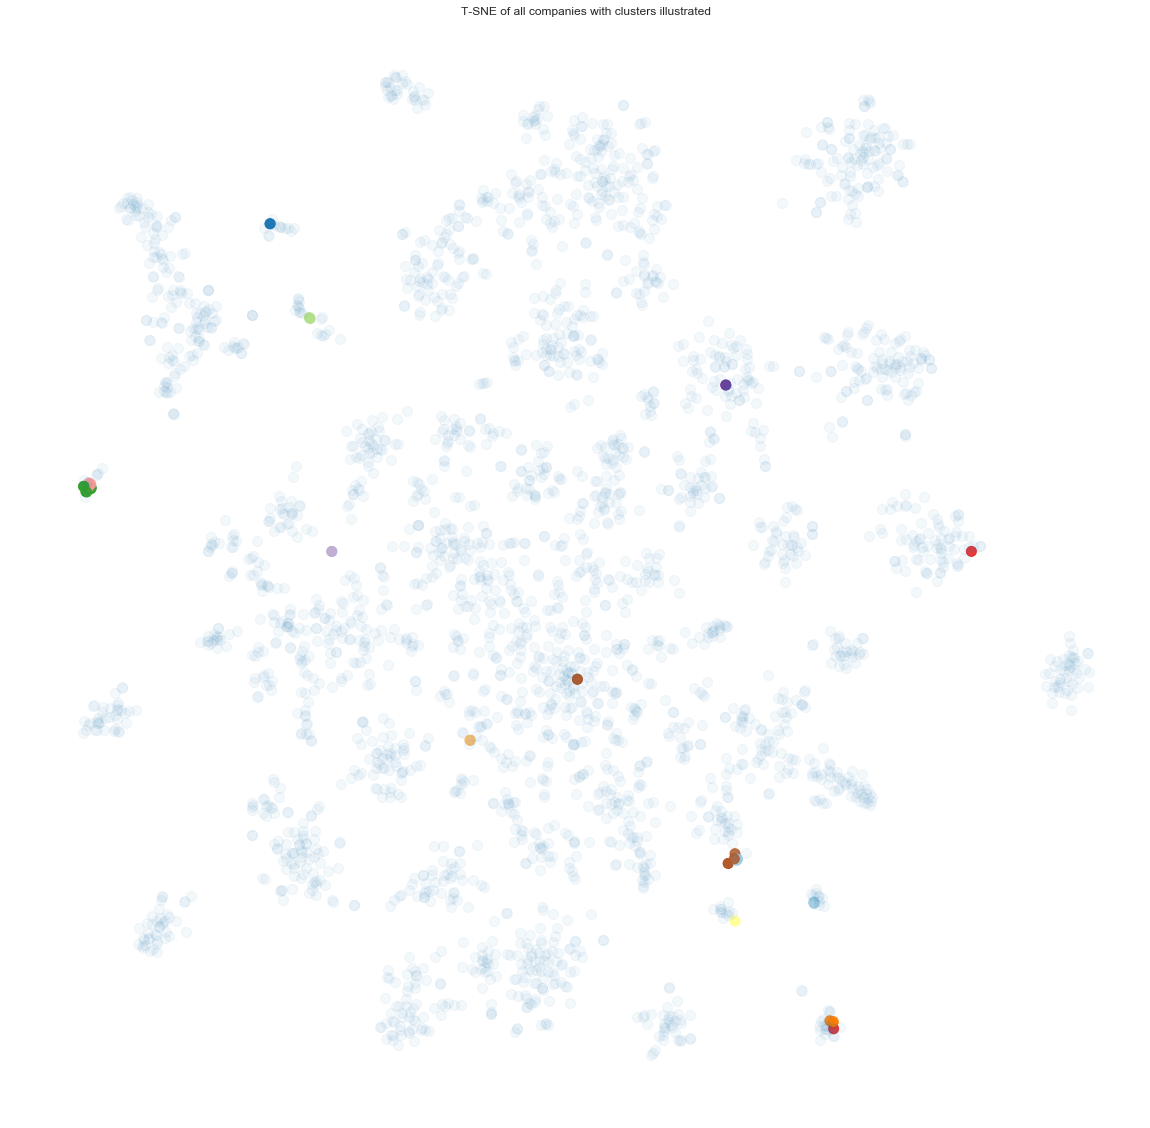

In [443]:
plt.figure(1, facecolor='white',figsize=(20,20))
plt.clf();
plt.axis('off');



plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
);

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
);

plt.title('T-SNE of all companies with clusters illustrated');